In [ ]:
from google.colab import files
uploaded = files.upload()
import utils

Saving utils.py to utils.py


In [ ]:
!cat utils.py

import torch
import torch.nn as nn

class MyConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch, dropout_p):
        kernel_size = 3
        super().__init__()

        self.model = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size, stride=1, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(),
            nn.Dropout(dropout_p),
            nn.MaxPool2d(2, stride=2)
        )

    def forward(self, x):
        return self.model(x)

def get_batch_accuracy(output, y, N):
    pred = output.argmax(dim=1, keepdim=True)
    correct = pred.eq(y.view_as(pred)).sum().item()
    return correct / N


def train(model, train_loader, train_N, random_trans, optimizer, loss_function):
    loss = 0
    accuracy = 0

    model.train()
    for x, y in train_loader:
        output = model(random_trans(x))
        optimizer.zero_grad()
        batch_loss = loss_function(output, y)
        batch_loss.backward()
        optimizer.step()

        loss += batch_loss.item(

In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/LAB AI/Jupyter Notebook/utils.py')
import utils


In [ ]:
!ls -l | grep utils


-rw-r--r-- 1 root root 1574 Jan  7 09:10 utils.py


In [ ]:
from importlib import reload
import utils
reload(utils)


<module 'utils' from '/content/utils.py'>

In [ ]:
!rm -rf __pycache__


In [ ]:
import utils
from importlib import reload
reload(utils)


<module 'utils' from '/content/utils.py'>

In [ ]:
import utils
utils.get_batch_accuracy


<function utils.get_batch_accuracy(output, y, N)>

In [ ]:
import torch.nn as nn
import pandas as pd
import torch
from torch.utils.data import DataLoader, Dataset
import numpy as np
from torch.optim import Adam
import matplotlib.pyplot as plt
import torchvision.transforms.v2 as transforms
import torchvision.io as tv_io
import torchvision.transforms.functional as F
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import utils
torch.cuda.is_available()

True

In [ ]:
IMG_HEIGHT = 28
IMG_WIDTH = 28
IMG_CHS = 1
n_classes = 24

train_df = pd.read_csv("/content/drive/MyDrive/LAB AI/Jupyter Notebook/mnist_train.csv.zip")
valid_df = pd.read_csv("/content/drive/MyDrive/LAB AI/Jupyter Notebook/mnist_test.csv.zip")


In [ ]:
train_df.head()

,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
valid_df.head()

,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


##1.Create Dataset, DataLoader

In [ ]:
class MyDataset(Dataset):
  def __init__(self,base_df):
    x_df = base_df.copy() #sao chép dữ liệu đầu vào để không thay đổi bản gốc.
    y_df = x_df.pop('label') # tách cột label làm biến đầu ra(nhãn)
    x_df = x_df.values/255 #chuẩn hóa dữ liệu nằm trong khoảng(0,1)
    x_df = x_df.reshape(-1,IMG_CHS,IMG_WIDTH,IMG_HEIGHT) # chuyển đổi dữ liệu thành định dạng phù hợp với mô hình CNN(số mẫu, số kênh ảnh, chiều rộng, chiều cao)
    self.xs = torch.tensor(x_df).float().to(device) # chuyển đổi dữ liệu thành Tensor và di chuyển nó vào thiết bị CPU/GPU
    self.ys = torch.tensor(y_df).to(device) # chuyển dữ liệu nhãn đầu ra thành Tensor và di chuyển nó vào thiết bị CPU/GPU

  def __getitem__(self,index): #hàm này chả về một mẫu dữ liệu tại chỉ số index, dữ liệu trả về là tuple(x,y). x: dữ liệu đầu vào tại chỉ số index, y: nhãn tương ứng
    return self.xs[index], self.ys[index]

  def __len__(self):# tổng số mẫu trong tập dữ liệu.
    return len(self.xs)

#Lí do để -1 trong đoạn code x.df.reshape(-1..): khi ta không chắc chắn về số lượng mẫu(batch_size) trong dữ liệu
#Khi cần chỉ định lại tensor theo các chiều cố định khác.




In [ ]:
n = 32
train_data = MyDataset(train_df)
train_loader = DataLoader(train_data, batch_size = n, shuffle = True)
train_N = len(train_loader.dataset)

valid_data = MyDataset(valid_df)
valid_loader = DataLoader(valid_data, batch_size = n)
valid_N = len(valid_loader.dataset)


##2.Build Model

In [ ]:
class MyConvBlock(nn.Module):
  def __init__(self,in_ch,out_ch,dropout_p):
      kernel_size = 3
      super().__init__()

      self.model = nn.Sequential(
      nn.Conv2d(in_ch,out_ch,kernel_size,stride = 1, padding = 1),
      nn.BatchNorm2d(out_ch),
      nn.ReLU(),
      nn.Dropout(dropout_p),
      nn.MaxPool2d(2,stride = 2)
      )

  def forward(self,x):
    return self.model(x)

In [ ]:
flatten_img_size = 75*3*3
#input: 1*28*28
base_model = nn.Sequential(
    MyConvBlock(IMG_CHS,25,0),
    MyConvBlock(25,50,0.2),
    MyConvBlock(50,75,0),
    #Flatten to dense layer
    nn.Flatten(), # chuyển tensor thành 1 vector phẳng
    nn.Linear(flatten_img_size,512), #Fully connected giữa số lượng giá trị đầu vào và số lượng node ẩn(ở đây là 512)
    nn.Dropout(.3),# Tắt ngẫu nhiên 30% node để giảm overfitting
    nn.ReLU(), # dùng hàm kích hoạt giúp mô hình học được những đặc trưng phi tuyến tính, tránh overfitting
    nn.Linear(512,n_classes), #dùng 512 lớp ẩn vừa rồi kết nối với số lượng lớp cần phân loại -> có số đầu ra tương ứng với số nhãn cần phân loại

)

model = torch.compile(base_model.to(device))
model


OptimizedModule(
  (_orig_mod): Sequential(
    (0): MyConvBlock(
      (model): Sequential(
        (0): Conv2d(1, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(25, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Dropout(p=0, inplace=False)
        (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
    )
    (1): MyConvBlock(
      (model): Sequential(
        (0): Conv2d(25, 50, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Dropout(p=0.2, inplace=False)
        (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
    )
    (2): MyConvBlock(
      (model): Sequential(
        (0): Conv2d(50, 75, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(75, eps=1e-05, momentum=0.1, affin

##3.Build Loss Function

In [ ]:
loss_function = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters())


In [ ]:
train_df.head(1)

,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


##4.Data Augumentation

In [ ]:
row_0 = train_df.head(1)
y_0 = row_0.pop('label')
x_0 = row_0.values/255
x_0 = x_0.reshape(IMG_CHS,IMG_WIDTH,IMG_HEIGHT)
x_0 = torch.tensor(x_0)
x_0.shape

torch.Size([1, 28, 28])

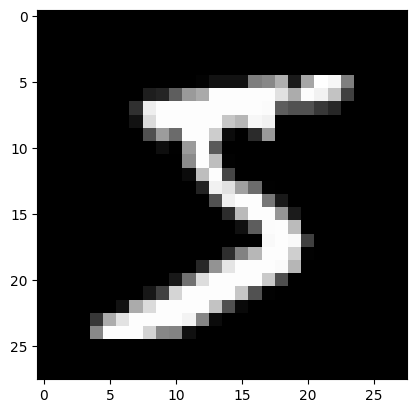

In [ ]:
image = F.to_pil_image(x_0[0])
plt.imshow(image, cmap = 'gray')

#4.1.RandomResizedCrop

In [ ]:
#RandomResizedCrop
trans = transforms.Compose([
    transforms.RandomResizedCrop((IMG_WIDTH,IMG_HEIGHT),scale = (.7,1), ratio = (1,1)),
])



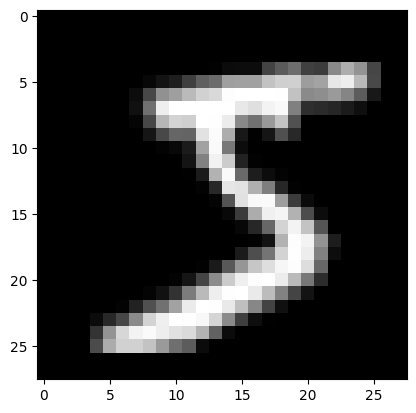

In [ ]:
new_x_0 = trans(x_0)
image = F.to_pil_image(new_x_0)
plt.imshow(image, cmap='gray')

In [ ]:
new_x_0.shape

torch.Size([1, 28, 28])

#.4.2.Horizontal Flip, Vertical Flip

In [ ]:
trans = transforms.Compose([
    transforms.RandomHorizontalFlip(),
])

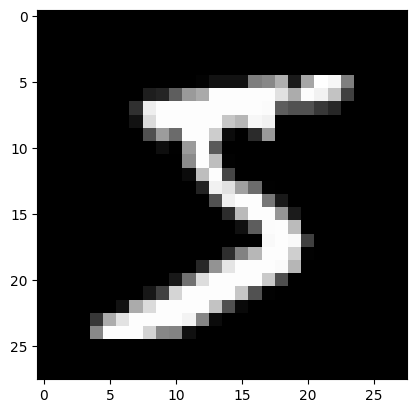

In [ ]:
new_x_0 = trans(x_0)
image = F.to_pil_image(new_x_0)
plt.imshow(image, cmap = 'gray')

In [ ]:
trans = transforms.Compose([
    transforms.RandomVerticalFlip(),
])

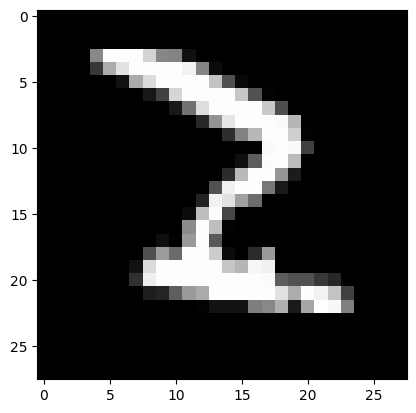

In [ ]:
new_x_1 = trans(x_0)
image = F.to_pil_image(new_x_1)
plt.imshow(image, cmap = 'gray')

#.4.3.RandomRotation

In [ ]:
trans = transforms.Compose([
    transforms.RandomRotation(30),
])

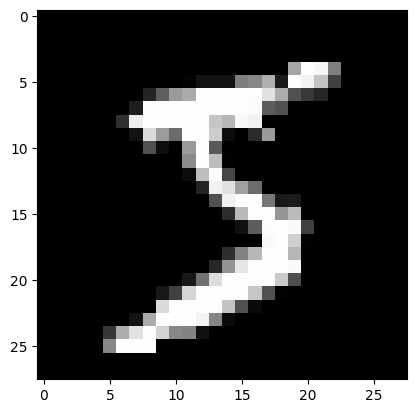

In [ ]:
new_x_2 = trans(x_0)
image = F.to_pil_image(new_x_2)
plt.imshow(image, cmap = 'gray')

#.4.4.ColorJitter

In [ ]:
brightness = .5
contrast = .5
trans = transforms.Compose([
    transforms.ColorJitter(brightness = brightness, contrast = contrast)
])

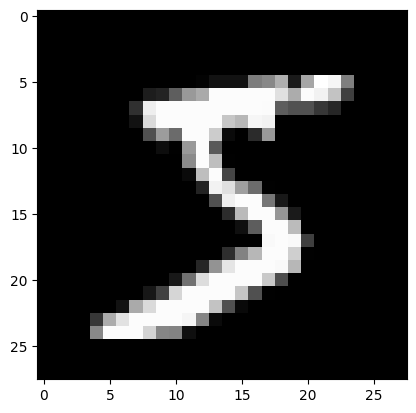

In [ ]:
new_x_3 = trans(x_0)
image = F.to_pil_image(new_x_3)
plt.imshow(image, cmap = 'gray')

#.4.5.Combine everything together

In [ ]:
random_transforms = transforms.Compose([
    transforms.RandomRotation(30),
    transforms.RandomResizedCrop((IMG_WIDTH, IMG_HEIGHT), scale = (.7,1), ratio = (1,1)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness = .2, contrast = .5)
])

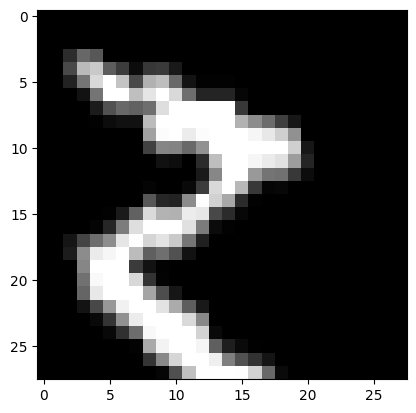

In [ ]:
new_img = random_transforms(x_0)
image = F.to_pil_image(new_img)
plt.imshow(image, cmap = 'gray')

In [ ]:
def get_batch_accuracy(output,y,N):
  predict = output.argmax(dim = 1, keepdim = True)
  correct = predict.eq(y.view_as(predict)).sum().item()
  return correct/N

#5.Train Model and Valid Model with Augumentation

In [ ]:
def train():
  loss = 0
  accuracy = 0
  for x,y in train_loader:
    output = model(random_transforms(x))
    optimizer.zero_grad()
    batch_loss = loss_function(output, y)
    batch_loss.backward()
    optimizer.step()

    loss += batch_loss.item()
    accuracy += utils.get_batch_accuracy(output, y, train_N)
  print('Train - Loss: {:.4f} Accuracy: {:.4f}'.format(loss,accuracy))

In [ ]:
def validate():
  loss, accuracy = 0,0
  model.eval()
  with torch.no_grad():
    for x,y in valid_loader:
      output = model(x)

      loss += loss_function(output,y).item()
      accuracy += utils.get_batch_accuracy(output,y, valid_N)
  print('Valid - Loss: {:.4f} Accuracy: {:.4f}'.format(loss, accuracy))

In [ ]:
import torch._dynamo
torch._dynamo.config.suppress_errors = True
epochs = 10
for epoch in range(epochs):
  print('Epoch: {}'.format(epoch))
  train()
  validate()

Epoch: 0


W0107 09:10:39.237000 1041 torch/_dynamo/convert_frame.py:1125] WON'T CONVERT inner /usr/local/lib/python3.10/dist-packages/torch/_dynamo/external_utils.py line 38 
W0107 09:10:39.237000 1041 torch/_dynamo/convert_frame.py:1125] due to: 
W0107 09:10:39.237000 1041 torch/_dynamo/convert_frame.py:1125] Traceback (most recent call last):
W0107 09:10:39.237000 1041 torch/_dynamo/convert_frame.py:1125]   File "/usr/local/lib/python3.10/dist-packages/torch/_dynamo/output_graph.py", line 1446, in _call_user_compiler
W0107 09:10:39.237000 1041 torch/_dynamo/convert_frame.py:1125]     compiled_fn = compiler_fn(gm, self.example_inputs())
W0107 09:10:39.237000 1041 torch/_dynamo/convert_frame.py:1125]   File "/usr/local/lib/python3.10/dist-packages/torch/_dynamo/repro/after_dynamo.py", line 129, in __call__
W0107 09:10:39.237000 1041 torch/_dynamo/convert_frame.py:1125]     compiled_gm = compiler_fn(gm, example_inputs)
W0107 09:10:39.237000 1041 torch/_dynamo/convert_frame.py:1125]   File "/usr/l

Train - Loss: 749.5916 Accuracy: 0.8715
Valid - Loss: 35.5146 Accuracy: 0.9607
Epoch: 1
Train - Loss: 343.0188 Accuracy: 0.9437
Valid - Loss: 26.1467 Accuracy: 0.9731
Epoch: 2
Train - Loss: 245.3936 Accuracy: 0.9594
Valid - Loss: 33.6063 Accuracy: 0.9648
Epoch: 3
Train - Loss: 215.9517 Accuracy: 0.9646
Valid - Loss: 18.6845 Accuracy: 0.9801
Epoch: 4
Train - Loss: 195.2233 Accuracy: 0.9675
Valid - Loss: 20.9093 Accuracy: 0.9799
Epoch: 5
Train - Loss: 178.4889 Accuracy: 0.9712
Valid - Loss: 21.2902 Accuracy: 0.9784
Epoch: 6
Train - Loss: 162.8331 Accuracy: 0.9724
Valid - Loss: 11.9122 Accuracy: 0.9875
Epoch: 7
Train - Loss: 162.1036 Accuracy: 0.9727
Valid - Loss: 18.5743 Accuracy: 0.9792
Epoch: 8
Train - Loss: 154.7563 Accuracy: 0.9744
Valid - Loss: 18.0208 Accuracy: 0.9794
Epoch: 9
Train - Loss: 149.0102 Accuracy: 0.9746
Valid - Loss: 19.1109 Accuracy: 0.9803


##6.Model Deployement

In [ ]:
torch.save(base_model,'model.pth')

In [ ]:
from utils import MyConvBlock


In [ ]:
model = torch.load('model.pth', map_location=device)
model

<ipython-input-41-bef24bd3aae5>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('model.pth', map_location=device)


Sequential(
  (0): MyConvBlock(
    (model): Sequential(
      (0): Conv2d(1, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(25, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Dropout(p=0, inplace=False)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
  )
  (1): MyConvBlock(
    (model): Sequential(
      (0): Conv2d(25, 50, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Dropout(p=0.2, inplace=False)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
  )
  (2): MyConvBlock(
    (model): Sequential(
      (0): Conv2d(50, 75, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(75, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Dropout(p=0, 

In [ ]:
next(model.parameters()).device

device(type='cuda', index=0)

##7.Show the images

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def show_image(image_path):
  image = mpimg.imread(image_path)
  plt.imshow(image,cmap = 'gray')


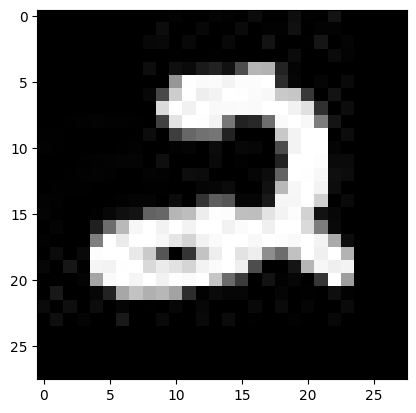

In [ ]:
show_image('/content/drive/MyDrive/LAB AI/Jupyter Notebook/img_1.jpg')

##8.Scaling the images

In [ ]:
image = tv_io.read_image('/content/drive/MyDrive/LAB AI/Jupyter Notebook/img_1.jpg',mode = tv_io.image.ImageReadMode.GRAY)
image

tensor([[[  0,   0,   0,   0,   0,   0,   0,   0,   0,   1,   3,   0,   0,   4,
            2,   0,  11,   0,   0,  14,   1,   0,  19,   0,   0,   0,   0,   0],
         [  0,   0,   0,   0,   0,   0,   0,   0,   0,  12,   0,   0,   7,   0,
            1,  10,   0,   2,   2,  16,   0,   3,   3,   0,   0,   0,   0,   0],
         [  0,   0,   0,   0,   0,   0,   0,   0,   7,   8,   0,   8,   0,   0,
            8,   0,   0,  19,   0,   0,   1,  21,   0,   4,   0,   0,   0,   0],
         [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   1,   0,   0,   1,
            0,   0,   0,   0,   0,  11,   0,   0,  10,   3,   0,   0,   0,   0],
         [  0,   0,   0,   0,   0,   0,   0,   0,  13,   0,  15,  10,  26,  34,
           17,  77, 181, 178,  35,   4,   0,   0,   0,   0,   0,   0,   0,   0],
         [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0, 150, 254, 250, 251,
          243, 252, 252, 255,  45,   6,   0,   5,   0,   9,   0,   0,   0,   0],
         [  0,   0,   0,   0,   0,

In [ ]:
image.shape

torch.Size([1, 28, 28])

In [ ]:
IMG_WIDTH = 28
IMG_HEIGHT = 28

preprocess_trans = transforms.Compose([
    transforms.ToDtype(torch.float32, scale=True), #Converts [0, 255] to [0, 1]
    transforms.Resize((IMG_WIDTH, IMG_HEIGHT)),
    transforms.Grayscale(),
])

In [ ]:
processed_image = preprocess_trans(image)
processed_image


tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0039, 0.0118, 0.0000, 0.0000, 0.0157, 0.0078, 0.0000,
          0.0431, 0.0000, 0.0000, 0.0549, 0.0039, 0.0000, 0.0745, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0471, 0.0000, 0.0000, 0.0275, 0.0000, 0.0039, 0.0392,
          0.0000, 0.0078, 0.0078, 0.0627, 0.0000, 0.0118, 0.0118, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0275, 0.0314, 0.0000, 0.0314, 0.0000, 0.0000, 0.0314, 0.0000,
          0.0000, 0.0745, 0.0000, 0.0000, 0.0039, 0.0824, 0.0000, 0.0157,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0039, 0.0000, 0.0000, 0.0039, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0431, 0.0000, 0.0000,

In [ ]:
processed_image.shape

torch.Size([1, 28, 28])

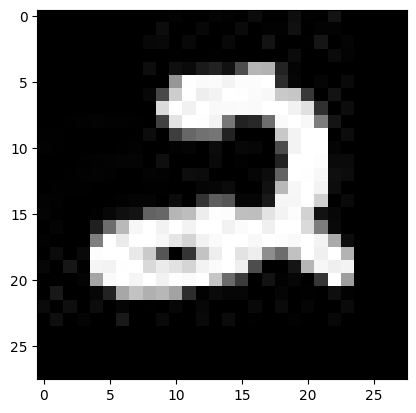

In [ ]:
plot_image = F.to_pil_image(processed_image)
plt.imshow(plot_image, cmap='gray')

##9.Making the predictions

In [ ]:
batched_image = processed_image.unsqueeze(0)
batched_image.shape

torch.Size([1, 1, 28, 28])

In [ ]:
batched_image_gpu = batched_image.to(device)
batched_image_gpu.device

device(type='cuda', index=0)

In [ ]:
output = model(batched_image_gpu)
output

tensor([[ -7.3034, -12.2440,  11.0608,  -4.5942,  -7.9337,  -1.0004,   1.7774,
          -6.3114,  -7.7947, -10.3600, -27.9123, -28.1951, -27.2644, -27.5079,
         -27.9746, -27.0490, -27.5965, -27.5800, -27.3617, -28.1182, -27.0689,
         -27.4643, -27.3596, -27.6706]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

##10.Understanding the Prediction

In [ ]:
prediction = output.argmax(dim = 1).item()
prediction

2

In [ ]:
digit = '0123456789'
digit[prediction]

'2'

In [ ]:
def predict_digit(image_path):
  show_image(image_path)
  image = tv_io.read_image(image_path,tv_io.ImageReadMode.GRAY)
  image = preprocess_trans(image)
  image = image.unsqueeze(0)
  image = image.to(device)
  output = model(image)
  prediction = output.argmax(dim = 1).item()
  predicted_digit = digit[prediction]
  return predicted_digit

'2'

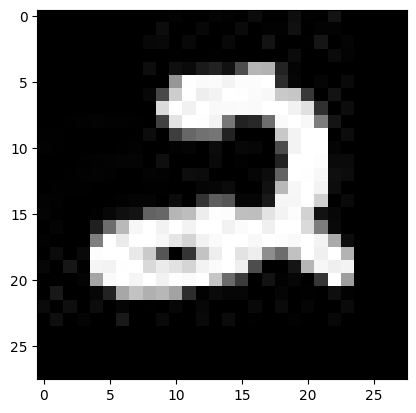

In [ ]:
predict_digit('/content/drive/MyDrive/LAB AI/Jupyter Notebook/img_1.jpg')

'3'

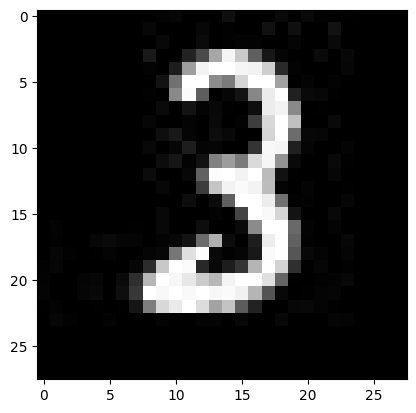

In [ ]:
predict_digit('/content/drive/MyDrive/LAB AI/Jupyter Notebook/img_5.jpg')

In [ ]:
import IPython
app = IPython.Application.instance()
app.kernel.do_shutdown(True)


{'status': 'ok', 'restart': True}